C:\Users\alex\AppData\Local\Temp\ipykernel_27248\4265021722.py:69: RuntimeWarning: invalid value encountered in sqrt
  frequency_decoupled = np.sqrt((default_properties['k_t'] - default_properties['l_a'] * default_properties['C_t'] * U_vals * U_vals) / default_properties['I'])
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


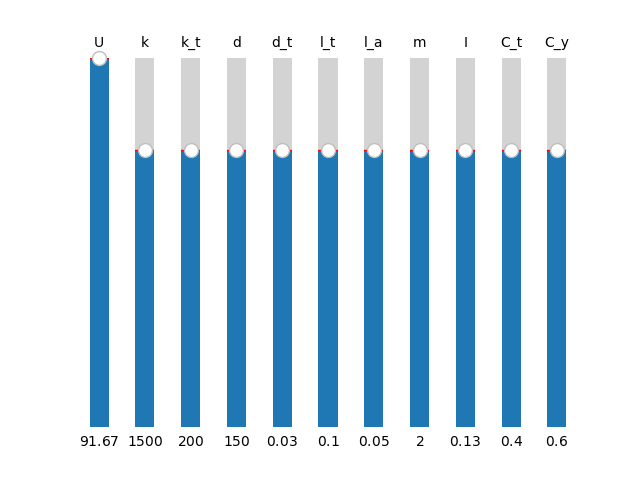

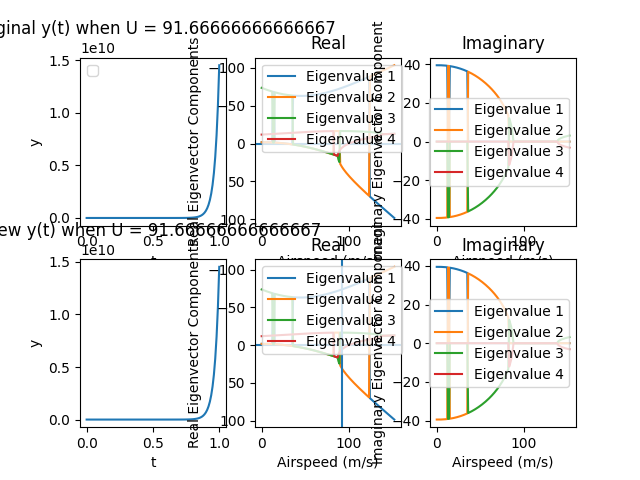

In [17]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider 

from wingsuit import WingsuitProperties, get_wingsuit_eigs, simulate

MAX_SPEED = 550 / 3.6 # Converts kmh to m/s

np.set_printoptions(linewidth=200)

default_properties: WingsuitProperties = {
    'k': 1500,
    'k_t': 200,

    'd': 150,
    'd_t': 0.03,
    
    'l_t': 0.1,
    'l_a': 0.05,

    'm': 2,
    'I': 0.13,

    'C_t': 0.4,
    'C_y': 0.6
}

# Part b numerical integration

def part_b():
    fig = plt.figure()
    axis = plt.axes()

    U_values = [240, 260]

    for U in U_values:
        new_properties = default_properties.copy()
        new_properties['l_t'] = 0
        new_properties['C_t'] = 0

        solution = simulate(new_properties, 1, 1, U)

        axis.plot(solution.t, solution.y[1], label=f'y(t) when U = {U}')

    axis.set_xlabel('t')
    axis.set_ylabel('y')
    axis.set_title("Solutions on either side of critical airspeed")
    fig.legend()

# part_b()

# Part C modal analysis

def plot_eigs(U_vals, eigs, axes, include_decoupled = False):
    real_axis, imaginary_axis = axes

    real_axis.set_xlabel('Airspeed (m/s)')
    real_axis.set_title(f"Real")
    real_axis.set_ylabel(f"Real Eigenvector Components")

    real_axis.invert_yaxis()
    real_axis.axhline(y=0)

    imaginary_axis.set_xlabel('Airspeed (m/s)')
    imaginary_axis.set_title('Imaginary')
    imaginary_axis.set_ylabel(f"Imaginary Eigenvector Component")

    frequency_decoupled = np.sqrt((default_properties['k_t'] - default_properties['l_a'] * default_properties['C_t'] * U_vals * U_vals) / default_properties['I'])
    damping_ratio_decoupled = (default_properties['d'] - default_properties['C_y'] * U_vals) / np.sqrt(default_properties['k'] * default_properties['m'])

    lines = { 'real': [], 'imaginary': [] }

    for i, eig_set in enumerate(eigs):
        [real_line] = real_axis.plot(U_vals, eig_set.real, label=f"Eigenvalue {i + 1}")
        [imaginary_line] = imaginary_axis.plot(U_vals, eig_set.imag, label=f"Eigenvalue {i + 1}")

        lines['real'].append(real_line)
        lines['imaginary'].append(imaginary_line)

    if include_decoupled:
        imaginary_axis.plot(U_vals, frequency_decoupled, 'b.', label="Decoupled Frequency")

    real_axis.legend(loc="upper left")
    imaginary_axis.legend()

    return lines

def part_c():
    U_vals = np.arange(0, MAX_SPEED, 1)

    eigs = get_wingsuit_eigs(default_properties, U_vals)

    fig, axes = plt.subplots(1, 2)

    plot_eigs(U_vals, eigs, axes, True)

# part_c()

# Part d design modification

def part_d():
    fig, axes = plt.subplots(2, 3)

    U_vals = np.arange(0, MAX_SPEED, 1)
    
    target_U = 330 / 3.6

    original_solution = simulate(default_properties, 1, 1, target_U)

    eigs = get_wingsuit_eigs(default_properties, U_vals)

    plot_eigs(U_vals, eigs, axes[0][1:])

    axes[0][0].plot(original_solution.t, original_solution.y[1])
    axes[0][0].set_xlabel('t')
    axes[0][0].set_ylabel('y')
    axes[0][0].legend()
    axes[0][0].set_title(f'Original y(t) when U = {target_U}')

    new_properties = default_properties.copy()

    new_solution = simulate(new_properties, 1, 1, target_U)
    new_eigs = get_wingsuit_eigs(new_properties, U_vals)

    eig_lines = plot_eigs(U_vals, new_eigs, axes[1][1:])

    [response_line] = axes[1][0].plot(new_solution.t, new_solution.y[1])
    axes[1][0].set_xlabel('t')
    axes[1][0].set_ylabel('y')
    axes[1][0].set_title(f'New y(t) when U = {target_U}')

    axes[1][1].axvline(x=target_U)

    fig, control_axes = plt.subplots(1, len(default_properties) + 1)

    sliders = {
        'U': Slider(
            ax=control_axes[0],
            label='U',
            valmin=0,
            valmax=330 / 3.6,
            valinit=target_U,
            orientation='vertical',
        )
    }
    
    def update(val):
        for key in sliders:
            new_properties[key] = sliders[key].val
        
        target_U = sliders['U'].val
        
        new_solution = simulate(new_properties, 1, 1, target_U)
        new_eigs = get_wingsuit_eigs(new_properties, U_vals)

        axes[1][0].set_title(f'New y(t) when U = {target_U}')

        response_line.set_data(new_solution.t, new_solution.y[1])

        for i, eigset in enumerate(new_eigs):
            eig_lines['real'][i].set_ydata(eigset.real)
            eig_lines['imaginary'][i].set_ydata(eigset.imag)
        
        fig.canvas.draw_idle()

    sliders['U'].on_changed(update)

    for i, key in enumerate(default_properties):
        valinit = default_properties[key]

        sliders[key] = Slider(
            ax=control_axes[i + 1],
            label=key,
            valmin=-valinit * 2,
            valmax=valinit * 2,
            valinit=valinit,
            orientation='vertical'
        )

        sliders[key].on_changed(update)

part_d()

plt.ion()
plt.show(block=True)

